In [1]:
from IPython import display
from pathlib import Path
import shutil
import yaml

display.clear_output()

# Load config
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Prevent ultralytics from tracking activity
!yolo settings sync=False

import ultralytics
ultralytics.checks()

Ultralytics 8.4.14 🚀 Python-3.13.11 torch-2.10.0 CPU (Apple M3 Pro)
Setup complete ✅ (11 CPUs, 36.0 GB RAM, 280.5/460.4 GB disk)


# Vision Pipeline Dataset Cleaner

**Purpose**: Clean and filter image dataset for computer vision tasks

**Pipeline Steps**:
1. Data Quality Check (CleanVision)
2. Person Detection (YOLOv8)
3. Full-body & Face Validation
4. Age/Gender Filtering
5. Advertisement Removal

In [2]:
from ultralytics import YOLO
from IPython.display import display, Image
from cleanvision import Imagelab
from tqdm import tqdm

/Users/carlychinsekyi/miniconda3/envs/vision/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Check dataset

In [ ]:
# Check original dataset
data_path = Path(f"../{config['paths']['original_raw']}")
image_count = len(list(data_path.rglob('*.png')))
print(f"Total images in original_raw: {image_count}")

Total images in original_raw: 1147


## CleanVision 
Clean dataset 
- did not remove odd aspect ratio because some images in the input dataset is already cropped
- source: https://github.com/cleanlab/cleanvision
- Future development: Create your own issue type by extending base class `IssueManager`.

Reading images from /Users/carlychinsekyi/Downloads/GitHub/vision-pipeline-dataset-cleaner/notebooks/../data/original_raw
Checking for exact_duplicates, near_duplicates, low_information, dark, light, blurry images ...


Computing scores: 100%|██████████| 1147/1147 [00:02<00:00, 409.22it/s]


Issue checks completed. 409 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | exact_duplicates |          279 |
|  1 | blurry           |           76 |
|  2 | dark             |           54 |
|  3 | near_duplicates  |            0 |
|  4 | low_information  |            0 |
|  5 | light            |            0 | 

----------------- exact_duplicates images ------------------

Number of examples with this issue: 279
Examples representing most severe instances of this issue:

Set: 0


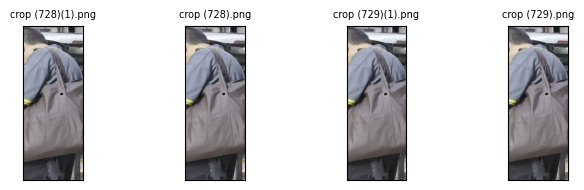

Set: 1


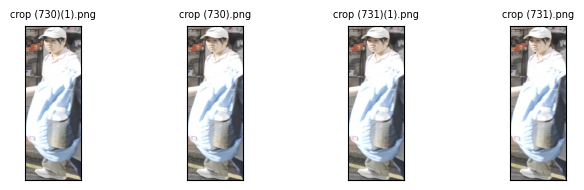

Set: 2


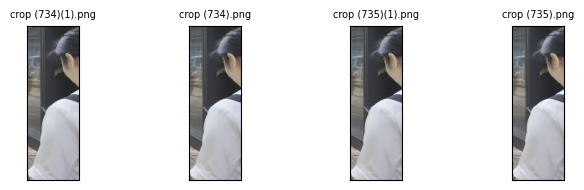

Set: 3


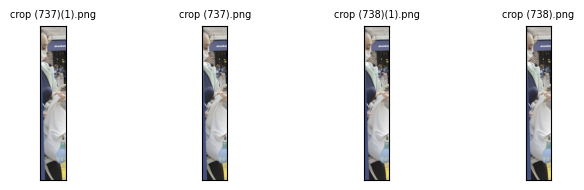

---------------------- blurry images -----------------------

Number of examples with this issue: 76
Examples representing most severe instances of this issue:



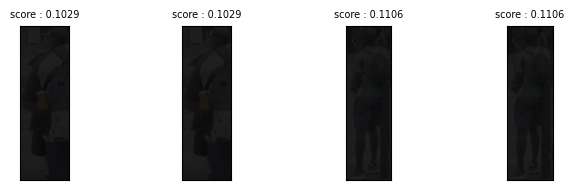

----------------------- dark images ------------------------

Number of examples with this issue: 54
Examples representing most severe instances of this issue:



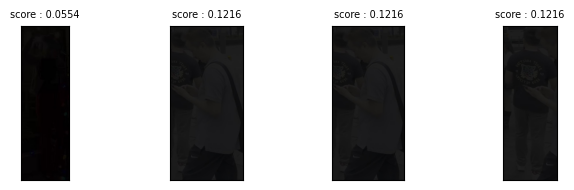

In [ ]:
imagelab = Imagelab(data_path=str(data_path))

# Build issue types from config
issue_types = {issue: {} for issue in config['cleanvision']['issue_types']}

imagelab.find_issues(issue_types)
imagelab.report()

In [ ]:
# Filter and copy clean images
issue_columns = [col for col in imagelab.issues.columns if col.startswith('is_') and col.endswith('_issue')]
clean_df = imagelab.issues[~imagelab.issues[issue_columns].any(axis=1)]
clean_names = set([Path(p).name for p in clean_df.index.tolist()])

# Recreate cleaned_raw directory
cleaned_data_path = Path(f"../{config['paths']['cleaned_raw']}")
if cleaned_data_path.exists():
    shutil.rmtree(cleaned_data_path)
cleaned_data_path.mkdir(exist_ok=True)

# Copy clean images only
good_images = 0
for img in sorted(data_path.glob('*.png')):
    if img.name in clean_names:
        shutil.copy(img, cleaned_data_path / img.name)
        good_images += 1

print(f"✓ Copied {good_images} clean images to {config['paths']['cleaned_raw']}/")
print(f"✗ Removed {len(imagelab.issues) - good_images} problematic images")

Deleted old ../data/cleaned_raw/
Copied 785 clean images to /data/cleaned_raw/
Removed 362 problematic images


In [ ]:
# Verify cleaned dataset
clean_image_count = len(list(cleaned_data_path.rglob('*.png')))
print(f"Total images in cleaned_raw: {clean_image_count}")

Total images: 785


**TODO**:
- In modular code, skip saving cleaned dataset - pass directly to next pipeline stage
- Determine optimal hyperparameters for CleanVision issue detection

---
# Phase 2: Person Detection with YOLO

**Confidence Threshold**:
- `conf=0.5` — Balanced (catches most people, some false positives)
- `conf=0.6` — Stricter (higher precision, fewer misses)
- `conf=0.8` — Very conservative (only obvious people)

**Model Options**:
- `yolov8n.pt` — Nano (fastest, lowest accuracy) ✓ Currently using
- `yolov8s.pt` — Small
- `yolov8m.pt` — Medium
- `yolov8l.pt` — Large
- `yolov8x.pt` — Extra large (slowest, highest accuracy)

In [ ]:
model = YOLO(f"../{config['models']['yolo']}")

# Run batch person detection with progress bar
all_results = {}
image_list = sorted(cleaned_data_path.glob('*.png'))

for img_path in tqdm(image_list, desc="Detecting persons"):
    results = model.predict(
        source=str(img_path), 
        conf=config['yolo']['confidence_threshold'], 
        verbose=False
    )
    result = results[0]
    
    # Filter to person class only (class 0 in COCO)
    person_boxes = result.boxes[result.boxes.cls == config['yolo']['person_class_id']]
    result.boxes = person_boxes
    all_results[img_path.name] = result

print(f"\n✓ Completed detection on {len(all_results)} images\n")

# Summary statistics
first_result = list(all_results.values())[0]
print(f"Sample from first image:")
print(f"  Persons detected: {len(first_result.boxes)}")
if len(first_result.boxes) > 0:
    print(f"  Confidence scores: {first_result.boxes.conf.cpu().numpy()}")

Running person detection on 785 images...
✓ Completed detection on 785 images

Sample from first image:
  Persons detected: 0


Image: crop (1000).png
Persons detected: 3
Saved to: annotated_crop (1000).png



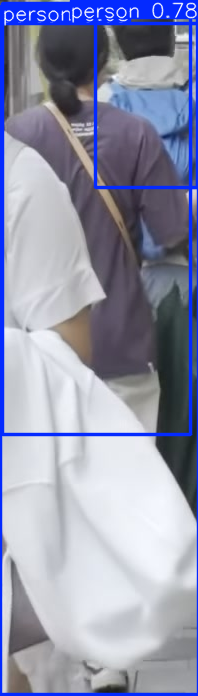

In [8]:
image_name = 'crop (1000).png'

if image_name in all_results:
    result = all_results[image_name]
    saved_path = result.save(filename=f'annotated_{image_name}')
    
    print(f"Image: {image_name}")
    print(f"Persons detected: {len(result.boxes)}")
    print(f"Saved to: {saved_path}\n")
    
    display(Image(saved_path))
else:
    print(f"❌ Image '{image_name}' not found")
    print(f"Available: {sorted(list(all_results.keys()))[:10]}...")

## Visualize Detection Results
Change `image_name` to view different annotated images